# Decision Trees

Debido a que los resultados obtenidos no cubren las necesidades del ejercicio, se plantea el uso de modelos de tipo Ensembles con el fin de dar una solución optima, para esto inicialmente se usara el arbol de decisión como punto de partida.


In [27]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import graphviz #Libreria utilizada para graficar el arbol de decisión
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV


In [28]:
model = DecisionTreeRegressor(max_depth=2) #Se instancia el modelo con una profundidad inicial de 2

In [29]:
X = pd.read_csv(r'C:\Scripts\Proyectos\Predicción_de_ingresos_peliculas\Data\X_opening_p.csv')
y = X['worldwide_gross']
X = X.drop('worldwide_gross',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [30]:
model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=2)

In [31]:
treedot = export_graphviz(model,out_file=None, feature_names=X.columns) #Se transforma el arbol de decisión a formato graphviz

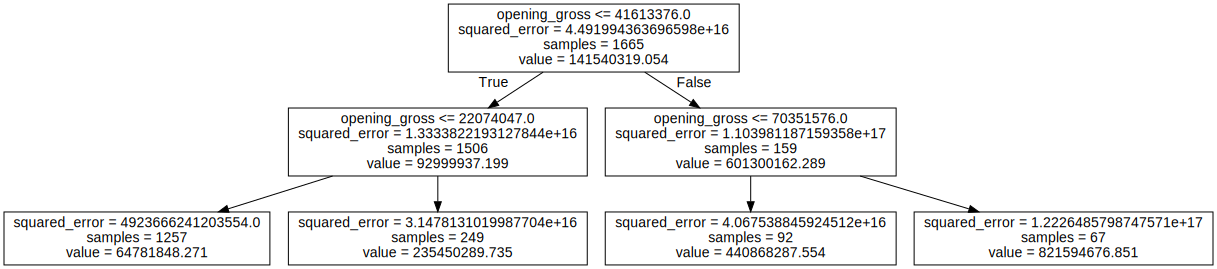

In [32]:
graphviz.Source(treedot)

# Implementación de Random Forest

In [33]:
forest = RandomForestRegressor(200) #Cantidad de arboles que se generan
results = cross_validate(forest,X,y,cv=5,scoring='r2',return_train_score=True)

In [34]:
test_scores = results['test_score']
train_scores = results['train_score']
print(np.mean(train_scores))
print(np.mean(test_scores))

0.9655374364233612
0.5175836053689362


Mejor resultado que Lasso! Ya no tenemos Bias y tenemos un mejor score r2. Sin embargo tenemos una
diferencia importante entre score de entrenamiento y de test (overfit).

**Debido a esto se implementara un Gradient Bossted Trees** y de igual forma se optimizaran sus hiperparametros con el fin de obtener un mejor resultado y eliminar el overfiting presentado.

In [35]:
ensemble = GradientBoostingRegressor()
results = cross_validate(ensemble,X,y,cv=5,scoring='r2',return_train_score=True)

In [36]:
test_scores = results['test_score']
train_scores = results['train_score']
print(np.mean(train_scores))
print(np.mean(test_scores))


0.9151392143549633
0.5253010115077634


Aunque se encuentra una situación parecida respecto al RF, el GBT presenta un mejor desempeño para el testing, por lo cual se procede a optimizar los hiper parametros.

# Optimización de hiperparametros

En esta sección del análisis se procedera a optimizar los hiperparametros del modelo y adicionalmente se aplicara el flujo de trabajo al mismo como si el modelo fuera a salir a producción.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1) # Se realiza la separación inicial de los df de training y testing

A continuación se hace un testing de los parametros por medio de GridSearch con el fin de definir el mejor performance.

**Nota=** Los parametros establecidos para los diversos arboles son tomados de diversas fuentes que los recomiendan de forma estandart.

In [38]:
param_test1 = {'n_estimators':range(20,501,20)} #Se establecen la cantidad de modelos debiles que se entrenaran en el GBR

estimator = GradientBoostingRegressor(learning_rate=0.1, #Parametro estimador
                                    min_samples_split=500,
                                    min_samples_leaf=50,
                                    max_depth=8,
                                    max_features='sqrt',
                                    subsample=0.8,
                                    random_state=10)

gsearch1 = GridSearchCV(estimator,
 param_grid = param_test1, #En esta sección se definen los diversos estimadores del modelo.
 scoring='r2', #Se parametriza el score a calcular
 cv=5,
 return_train_score = True) #Se define la cantidad de validaciones cruzadas a realizar.


In [39]:
 gsearch1.fit(X_train,y_train) #Se realiza el entrenamiento del modelo

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(max_depth=8,
                                                 max_features='sqrt',
                                                 min_samples_leaf=50,
                                                 min_samples_split=500,
                                                 random_state=10,
                                                 subsample=0.8),
             param_grid={'n_estimators': range(20, 501, 20)},
             return_train_score=True, scoring='r2')

In [40]:
#Se optienen los diferentes parametros con el fin de evaluar cuales fueron los mejores
list(zip(gsearch1.cv_results_['mean_test_score'], gsearch1.cv_results_['std_test_score'], gsearch1.cv_results_['params'])) 

[(0.6553377167287445, 0.05763723230388878, {'n_estimators': 20}),
 (0.7194707183052496, 0.06255974658122894, {'n_estimators': 40}),
 (0.7347239263041044, 0.06359927761595936, {'n_estimators': 60}),
 (0.7389339055742862, 0.062364772765764416, {'n_estimators': 80}),
 (0.7420485206288181, 0.06271425977283825, {'n_estimators': 100}),
 (0.7459322395926498, 0.06235500960463639, {'n_estimators': 120}),
 (0.7495406754127887, 0.06335029572288611, {'n_estimators': 140}),
 (0.7508197586274827, 0.06304688375599073, {'n_estimators': 160}),
 (0.7525654539309128, 0.0634404813604329, {'n_estimators': 180}),
 (0.753490598609423, 0.06446653281824145, {'n_estimators': 200}),
 (0.7545692717605135, 0.06341510679393178, {'n_estimators': 220}),
 (0.7553059694284988, 0.06488882352873111, {'n_estimators': 240}),
 (0.755171486028867, 0.06572082397934954, {'n_estimators': 260}),
 (0.753885223323653, 0.06495415209551623, {'n_estimators': 280}),
 (0.7546023133872947, 0.06568746888772702, {'n_estimators': 300}),
 (

Posterior a la validación realizada, se encuentra que los parametros establecidos la mejor cantidad de estimadores para el modelo es de **240**, esto se puede corroborar a continuación:

In [41]:
gsearch1.best_estimator_

GradientBoostingRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=50,
                          min_samples_split=500, n_estimators=240,
                          random_state=10, subsample=0.8)

Sin embargo con el fin de establecer que los parametros si son los indicados se hace una validación final de los score y se identifica el estado del overfiting anteriormente presentado:

In [47]:
cross_validate(gsearch1.best_estimator_,X_train,y_train,return_train_score = True)


{'fit_time': array([0.59263134, 0.33279634, 0.33379412, 0.32180047, 0.32879972]),
 'score_time': array([0.0039978 , 0.00399613, 0.00499606, 0.00399613, 0.00599289]),
 'test_score': array([0.70503564, 0.66126336, 0.84330169, 0.79674271, 0.77018645]),
 'train_score': array([0.84023253, 0.84280927, 0.80824339, 0.82833448, 0.82368469])}

In [45]:
final_results = cross_validate(gsearch1.best_estimator_,X_train,y_train,return_train_score = True)


In [46]:
test_scores = final_results['test_score']
train_scores = final_results['train_score']
print(np.mean(train_scores))
print(np.mean(test_scores))


0.8286608694466742
0.7553059694284988


Como se puede ver finalmente se obtuvo un modelo con un overfiting bastante bajo y optimo para enviar a producción el modelo.

Dados los resultados se procede a calcular el score final del modelo con los mejores parametros encontrados.

In [49]:
stimator = GradientBoostingRegressor(learning_rate=0.1, #Parametro estimador
                                    min_samples_split=500,
                                    min_samples_leaf=50,
                                    max_depth=8,
                                    max_features='sqrt',
                                    subsample=0.8,
                                    random_state=10,
                                    n_estimators=240)

In [51]:
estimator.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=50,
                          min_samples_split=500, random_state=10,
                          subsample=0.8)

In [52]:
estimator.score(X_test,y_test)

0.8092629870676818

### Finalmente se pasa de un score de 0.4 a uno de 0.8 en terminos de r2, debido al proceso de mejoramiento de features, haber cambiado el modelo y realizando la optimización de los hiperparametros del mismo.